# HW_06 Бондаренко Алексей (bondaleksey@gmail.com)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV, RidgeClassifierCV
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from sklearn.metrics import classification_report 
from datetime import datetime
from datetime import timedelta



# Цель проекта 
Цель проекта: построить модель, которая предсказывает пассажиропоток в ближайшее время

План выполнения работы:
- Базовый EDA
- Генерация дополнительных признаков
- Baseline прогноз и проверка качества
- Построение различных моделей

# 1 Данные

## 1.1 Описание данных
 Признаки [набора данных](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

 - holiday (Categorical) -  US National holidays plus regional holiday, Minnesota State Fair
 - temp (Numeric) -  Average temp in kelvin
 - rain_1h (Numeric) -  Amount in mm of rain that occurred in the hour
 - snow_1h (Numeric) - Amount in mm of snow that occurred in the hour
 - clouds_all (Numeric) - Percentage of cloud cover
 - weather_main (Categorical) - Short textual description of the current weather
 - weather_description (Categorical) - Longer textual description of the current weather
 - date_time (DateTime) - Hour of the data collected in local CST time
 - traffic_volume (Numeric) - Hourly I-94 ATR 301 reported westbound traffic volume

In [2]:
data = pd.read_csv('data_ts/archive.csv.gz',compression='gzip', header=0, sep=',', quotechar='"',index_col=0)                  

In [3]:
data.head(5)

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
holiday,,,,,,,,
None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data = data.reset_index();

## 1.2 Разведывательный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [6]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [7]:
def EDA(data):
    cols = data.columns
    print('Printing figures for columns:\n',cols)
    for item in cols:
        if item=='date_time':
            continue
        print("Look at column:", item)
        dt = data[item].dtype          
        if dt == 'int64'or dt == 'float64':        
            ax = data[item].plot(kind = 'hist', bins = 50)
            ax.set_xlabel(item)
            plt.show()
        elif dt == 'object':
            ax = data[item].value_counts().plot(kind = 'bar')
            ax.set_xlabel(item)
            plt.show()
        else:
            print(f'ooops, have problems with {item}')

Printing figures for columns:
 Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')
Look at column: holiday


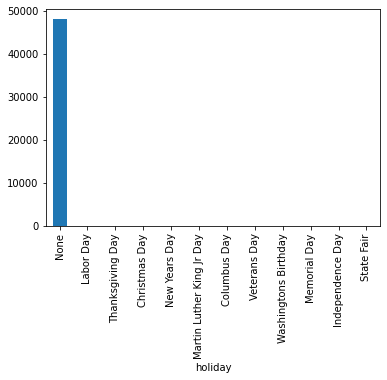

Look at column: temp


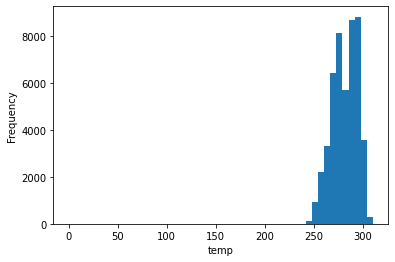

Look at column: rain_1h


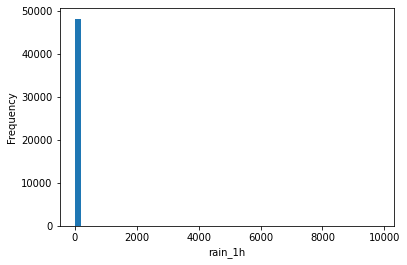

Look at column: snow_1h


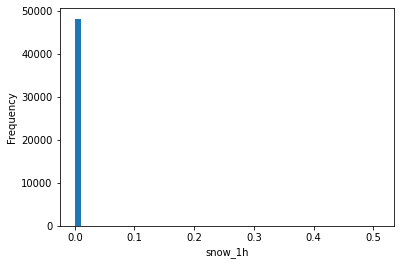

Look at column: clouds_all


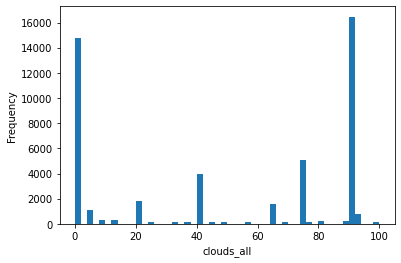

Look at column: weather_main


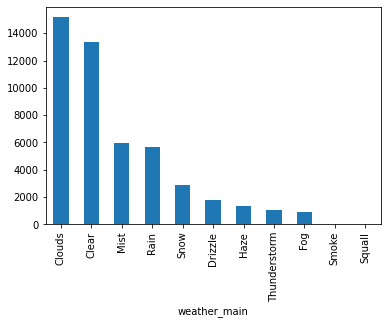

Look at column: weather_description


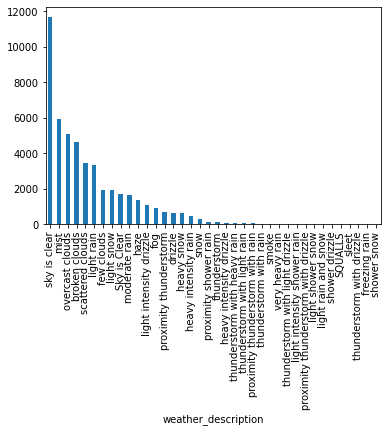

Look at column: traffic_volume


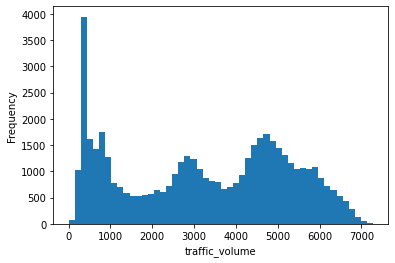

In [8]:
EDA(data)

Признаки, можно празники посмотреть и сравнить поведение в праздники и не в праздники... 
То есть праздники поставить как bool  1 

 ## 1.3 Преобразование данных и выбор признаков

### 1.3.1 Убираем дубликаты 

In [9]:
data.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [10]:
wdata = data[['date_time','holiday','temp','traffic_volume']].copy()
wdata['date_time'] = pd.to_datetime(wdata['date_time'])
wdata = wdata.set_index('date_time')
wdata = wdata.drop_duplicates()

In [11]:
wdata.head()

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545
2012-10-02 10:00:00,None,289.36,4516
2012-10-02 11:00:00,None,289.58,4767
2012-10-02 12:00:00,None,290.13,5026
2012-10-02 13:00:00,None,291.14,4918


In [12]:
wdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40606 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40606 non-null  object 
 1   temp            40606 non-null  float64
 2   traffic_volume  40606 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


In [13]:
40606/(24*365)

4.635388127853881

### 1.3.2 Добавляем пропуски в записи данных по времени 

 А в информации данных указано, что период времени в данных почти 6 лет. Значит есть пропуски в данных.

In [14]:
print(wdata.loc['2012-11-05 13:00:00':'2012-11-05 21:00:00'])

                    holiday    temp  traffic_volume
date_time                                          
2012-11-05 13:00:00    None  278.47            4648
2012-11-05 14:00:00    None  278.71            4968
2012-11-05 16:00:00    None  280.56            6124
2012-11-05 17:00:00    None  280.56            6134
2012-11-05 18:00:00    None  279.26            4265
2012-11-05 20:00:00    None  280.56            2415
2012-11-05 21:00:00    None  280.56            1963


Как мы видим отсутствуют значения для 15 и 19 часов.

In [15]:
right_dates = pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')
len(right_dates)

52551

In [16]:
# for ind, item in enumerate(right_dates):
    
#     if ind >10000:
#         break
#     if ind %(24*15)==0:
#         print("month = ",item.month)

Создадим пустой датафрейм с правильной индексацией по времени и потом объединим его с предварительно обработанными данными.

In [17]:
# wdata['date_time'] = pd.to_datetime(wdata['date_time'])

In [18]:
my_df = pd.DataFrame({'date_time': right_dates}).set_index('date_time')
my_df.head(3)

""
date_time
2012-10-02 09:00:00
2012-10-02 10:00:00
2012-10-02 11:00:00


In [19]:
print(type(my_df.index[1]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [20]:
print((my_df.index[1]-my_df.index[0]))

0 days 01:00:00


In [21]:
clean_data = my_df.join(wdata)
clean_data.head(3)

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545.0
2012-10-02 10:00:00,None,289.36,4516.0
2012-10-02 11:00:00,None,289.58,4767.0


In [22]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52629 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40606 non-null  object 
 1   temp            40606 non-null  float64
 2   traffic_volume  40606 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


Число строчек в полученном DataFrame 52629, а число дат в нужном диапазоне = 52551.

In [23]:
(629-551)*2

156

### 1.3.3 Исправляем двойные значения в данных температуры

In [24]:
dupl = clean_data.index.duplicated(keep='last')
dupl.sum()

78

In [25]:
clean_data[clean_data.index.duplicated(keep=False)].head(6)

,holiday,temp,traffic_volume
date_time,,,
2012-11-04 01:00:00,None,275.60,730.0
2012-11-04 01:00:00,None,275.77,730.0
2014-01-03 20:00:00,None,267.97,2427.0
2014-01-03 20:00:00,None,268.88,2427.0
2014-01-09 16:00:00,None,265.73,6421.0
2014-01-09 16:00:00,None,266.47,6421.0


In [26]:
 working_data = clean_data[~dupl].copy()

In [27]:
working_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            40528 non-null  float64
 2   traffic_volume  40528 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


In [28]:
month_number = list(map(lambda x: int(x.month),right_dates))
is_weekend = list(map(lambda x: int(x.dayofweek>4),right_dates))

In [29]:
working_data['is_holiday'] = working_data[working_data['holiday'].notna()]['holiday'].apply(lambda x: 0 if x == 'None' else 1)

In [30]:
# clean_data['is_weekend'] = pd.Series(is_weekend).values
working_data['is_weekend'] = is_weekend
working_data['month_number'] = month_number

In [31]:
working_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            40528 non-null  float64
 2   traffic_volume  40528 non-null  float64
 3   is_holiday      40528 non-null  float64
 4   is_weekend      52551 non-null  int64  
 5   month_number    52551 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 2.8+ MB


In [32]:
 in_data = working_data.interpolate(method='linear', axis=0).copy()

In [33]:
in_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            52551 non-null  float64
 2   traffic_volume  52551 non-null  float64
 3   is_holiday      52551 non-null  float64
 4   is_weekend      52551 non-null  int64  
 5   month_number    52551 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 2.8+ MB


In [34]:
in_data.describe()

,temp,traffic_volume,is_holiday,is_weekend,month_number
count,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000
mean,282.501583,3071.897557,0.001056,0.285894,6.521779
std,12.993132,1922.467889,0.032113,0.451843,3.448434
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,273.580000,1223.599161,0.000000,0.000000,4.000000
50%,286.420000,2897.000000,0.000000,0.000000,7.000000
75%,291.703441,4775.000000,0.000000,1.000000,10.000000
max,310.070000,7280.000000,1.000000,1.000000,12.000000


In [35]:
# Посмотрим на даты обозначенные как праздничные
# working_data['is_holiday'].sum()
# in_data[in_data['is_holiday']==1].head(60)

In [36]:
test_data = working_data.loc['2013-10-13 00:00:00':'2013-10-14 05:00:00'].copy()

In [37]:
in_data.loc['2013-10-13 22:00:00':'2013-10-14 05:00:00'].head(20)

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number
date_time,,,,,,
2013-10-13 22:00:00,NaN,279.835714,1693.857143,0.0,1,10
2013-10-13 23:00:00,None,278.580000,1084.000000,0.0,1,10
2013-10-14 00:00:00,Columbus Day,277.720000,615.000000,1.0,0,10
2013-10-14 01:00:00,NaN,277.395000,453.000000,0.5,0,10
2013-10-14 02:00:00,None,277.070000,291.000000,0.0,0,10
2013-10-14 03:00:00,None,276.700000,388.000000,0.0,0,10
2013-10-14 04:00:00,NaN,277.145000,1541.000000,0.0,0,10
2013-10-14 05:00:00,None,277.590000,2694.000000,0.0,0,10


In [38]:
in_data['was_nan'] = working_data['traffic_volume'].isnull().astype(int)
in_data.head()

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2012-10-02 09:00:00,None,288.28,5545.0,0.0,0,10,0
2012-10-02 10:00:00,None,289.36,4516.0,0.0,0,10,0
2012-10-02 11:00:00,None,289.58,4767.0,0.0,0,10,0
2012-10-02 12:00:00,None,290.13,5026.0,0.0,0,10,0
2012-10-02 13:00:00,None,291.14,4918.0,0.0,0,10,0


### Неожиданности 
Так как в дата сете есть целые пропущенные дни, то возможно надо либо эти прощенные данные выкинуть, а оставшиеся использовать
либо пометить их как-то
Но ключевой вопрос, сколько у тебя интервалов прощенных данных и какова была их длинна? 


In [39]:
pd.unique(working_data['holiday'])

array(['None', nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [40]:
def add_holidays(df):
       holidays = ['Columbus Day', 'Veterans Day', 'Thanksgiving Day',
                   'Christmas Day', 'New Years Day', 'Washingtons Birthday',
                   'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
                   'Martin Luther King Jr Day']
       out = df[df['holiday'].isin(holidays)]
       delta_hour = timedelta(hours=1)
       for day in out.index:
              for i in range(1,24,1):
                     df.loc[day+delta_hour*i,'is_holiday'] = 1       
       # print(out.head())
       # print(df[df['holiday'].isin(holidays)].head())
       

In [41]:
# print(working_data.index[2]-working_data.index[1])
# print(type(working_data.index[2]-working_data.index[1]))

In [42]:
# from datetime import timedelta
# t = timedelta(hours=10.56)
# print(t)

In [43]:
add_holidays(in_data)

In [44]:
in_data['is_holiday'].sum()

1273.0

In [45]:
in_data.loc['2013-10-13 22:00:00':'2013-10-15 03:00:00'].head(50)

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2013-10-13 22:00:00,NaN,279.835714,1693.857143,0.0,1,10,1
2013-10-13 23:00:00,None,278.580000,1084.000000,0.0,1,10,0
2013-10-14 00:00:00,Columbus Day,277.720000,615.000000,1.0,0,10,0
2013-10-14 01:00:00,NaN,277.395000,453.000000,1.0,0,10,1
2013-10-14 02:00:00,None,277.070000,291.000000,1.0,0,10,0
2013-10-14 03:00:00,None,276.700000,388.000000,1.0,0,10,0
2013-10-14 04:00:00,NaN,277.145000,1541.000000,1.0,0,10,1
2013-10-14 05:00:00,None,277.590000,2694.000000,1.0,0,10,0
2013-10-14 06:00:00,None,277.990000,5729.000000,1.0,0,10,0


In [46]:
in_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            52551 non-null  float64
 2   traffic_volume  52551 non-null  float64
 3   is_holiday      52551 non-null  float64
 4   is_weekend      52551 non-null  int64  
 5   month_number    52551 non-null  int64  
 6   was_nan         52551 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 5.0+ MB


In [47]:
in_data.describe()

,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
count,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000
mean,282.501583,3071.897557,0.024224,0.285894,6.521779,0.228787
std,12.993132,1922.467889,0.153715,0.451843,3.448434,0.420056
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,273.580000,1223.599161,0.000000,0.000000,4.000000,0.000000
50%,286.420000,2897.000000,0.000000,0.000000,7.000000,0.000000
75%,291.703441,4775.000000,0.000000,1.000000,10.000000,0.000000
max,310.070000,7280.000000,1.000000,1.000000,12.000000,1.000000


In [48]:
print(pd.unique(in_data['is_holiday']))

[0.  1.  0.5]


In [60]:
in_data.loc[in_data[in_data['is_holiday']==0.5].index,'is_holiday']=0

In [53]:
test_data.head(60)

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number
date_time,,,,,,
2013-10-13 00:00:00,None,280.38,1489.0,0.0,1,10
2013-10-13 01:00:00,NaN,NaN,NaN,NaN,1,10
2013-10-13 02:00:00,None,279.52,730.0,0.0,1,10
2013-10-13 03:00:00,None,278.55,415.0,0.0,1,10
2013-10-13 04:00:00,None,277.00,351.0,0.0,1,10
2013-10-13 05:00:00,NaN,NaN,NaN,NaN,1,10
2013-10-13 06:00:00,NaN,NaN,NaN,NaN,1,10
2013-10-13 07:00:00,NaN,NaN,NaN,NaN,1,10
2013-10-13 08:00:00,NaN,NaN,NaN,NaN,1,10


In [77]:
def NAN_analysis(df):
    """Наверно лучше сделать численные индексы ... ??? или любые??? Мы же итерроус пройдемся  ... """
       
    # out = df[['traffic_volume','temp']].isnull().astype(int).groupby(df[['traffic_volume','temp']].notnull().astype(int).cumsum()).sum()
    # df['index'] = df[df['traffic_volume'].isnull()].index
    out_nans = {}
    delta_hour = timedelta(hours=1)
    out_data = df[df['traffic_volume'].isnull()].copy()
    out_data = out_data.reset_index()
    out_data['shifted'] = out_data['date_time'].shift(-1)
    # out['shifted'] = out.iloc[:,0].shift(-1)
    # row_start = out.iloc[0,0]
    start_nans = out_data.iloc[0,0]
    end_nans = None
    count_nans = 1
    for ind, row in out_data.iterrows():
        if row['shifted']-row['date_time'] > delta_hour:
            end_nans = row['date_time']
            out_nans[start_nans] = (count_nans,end_nans) 
            count_nans = 1
            start_nans = row['shifted']
            end_nans = None
        else:
            count_nans+=1
    
    # out = df[df['traffic_volume'].isnull()]
    # df['shifted_index'] = out.index.shift(-1)
    # out = df['shifted_index'].copy()
    # .groupby(df['traffic_volume'].notnull().astype(int).cumsum()).sum()
    return out_data, out_nans
    

In [78]:
out_data, out_nans = NAN_analysis(test_data)
out_data.head(50)

AttributeError: 'tuple' object has no attribute 'head'

In [73]:
out_intervals.iloc[1,1]

nan

In [51]:
# na_intervals = NAN_analysis(working_data)
# na_intervals = NAN_analysis(test_data)

In [52]:
def plot_data(df):
    N = 100
    h = int(np.ceil(len(df.index)/N))    
    # for i in range(N-1):
    a = h
    b = 2*h
    # a = 500
    # b = 520
    
    df.iloc[a:b,1].plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    df.iloc[a:b,2].plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    print(f" h = {h}, a = {a}, b = {b}")

plot_data()

TypeError: plot_data() missing 1 required positional argument: 'df'

In [ ]:
def plot_data2(df):
    N = 100
    h = int(np.ceil(len(df.index)/N))    
    # for i in range(N-1):
    # a = h
    # b = 2*h
    a = 750
    b = 800
    
    df.iloc[a:b,1].plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    df.iloc[a:b,2].plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    print(f" h = {h}, a = {a}, b = {b}")
    print(df.iloc[a:b,:])

# plot_data2(wdata)